<a href="https://colab.research.google.com/github/chirayu-khandelwal/Parkinson_Detection/blob/main/ParkinsonsDetectionfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson's Disease Detection using Voice Features

## 1. Importing Libraries

In [1]:
# Standard Libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os # For checking if file exists

# Scikit-learn for ML tasks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve
)

# Imbalanced-learn for handling class imbalance
!pip install imblearn
from imblearn.over_sampling import SMOTE

# XGBoost
!pip install xgboost
from xgboost import XGBClassifier

# IPython specific
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


## 2. Data Loading and Initial Exploration

In [2]:
# URL for the UCI Parkinson's Voice Dataset
url_string = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
local_filename = 'parkinsons_voice_data.csv'

# Download the data if it doesn't exist locally
if not os.path.exists(local_filename):
    print(f"Downloading data from {url_string}...")
    try:
        url_content = requests.get(url_string).content
        with open(local_filename, 'wb') as data_file:
            data_file.write(url_content)
        print("Data downloaded successfully.")
    except Exception as e:
        print(f"Error downloading data: {e}")
        # Consider exiting or raising an error depending on desired behavior
else:
    print(f"Using existing local file: {local_filename}")

# Read Data into Pandas Dataframe
try:
    df = pd.read_csv(local_filename)
    print("Data loaded successfully into DataFrame.")
except Exception as e:
    print(f"Error reading data file: {e}")
    # Consider exiting or raising an error

Data downloaded successfully.
Data loaded successfully into DataFrame.


In [3]:
print("\n--- Initial Data Exploration ---")
display(df.head())


--- Initial Data Exploration ---


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
display(df.tail())

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306
194,phon_R01_S50_6,214.289,260.277,77.973,0.00567,0.00003,0.00295,0.00317,0.00885,0.01884,...,0.03078,0.04398,21.209,0,0.462803,0.664357,-5.724056,0.190667,2.555477,0.148569


In [5]:
print(f"Dataset Shape (Instances, Features): {df.shape}")

Dataset Shape (Instances, Features): (195, 24)


## 3. Data Preprocessing

In [6]:
print("\n--- Data Preprocessing ---")
# Drop the 'name' column as it's an identifier
if 'name' in df.columns:
    df.drop(['name'], axis=1, inplace=True)
    print("Dropped 'name' column.")
    print(f"Shape after dropping 'name': {df.shape}")
else:
    print("'name' column not found or already dropped.")


--- Data Preprocessing ---
Dropped 'name' column.
Shape after dropping 'name': (195, 23)


In [7]:
# Check data types and basic stats
print("\nDataFrame Info:")
df.info() # Check for non-numeric types


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-n

In [8]:
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [9]:
# Ensure 'status' is numeric and handle potential errors
if 'status' in df.columns:
    df['status'] = pd.to_numeric(df['status'], errors='coerce')
    df.dropna(subset=['status'], inplace=True) # Remove rows where status is not valid
    df['status'] = df['status'].astype('uint8')
    print("\nEnsured 'status' column is numeric (uint8).")
else:
    print("Error: 'status' column not found.")
    # Exit or handle error

df.info()


Ensured 'status' column is numeric (uint8).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16 

In [10]:
# Check for duplicates and missing values
print(f"\nNumber of Duplicated Rows: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    # Optional: df.drop_duplicates(inplace=True)
    print("Consider handling duplicate rows if necessary.")

print("\nMissing Values per Column:")
print(df.isna().sum()) # Should show 0 for this dataset
if df.isna().any().any():
    # Optional: Add imputation strategy if needed
    print("Warning: Missing values detected. Imputation might be needed.")


Number of Duplicated Rows: 0

Missing Values per Column:
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


### 3.1 Exploratory Data Analysis (Visualizations)


Class Distribution (0: Healthy, 1: Parkinson's):
status
1    147
0     48
Name: count, dtype: int64


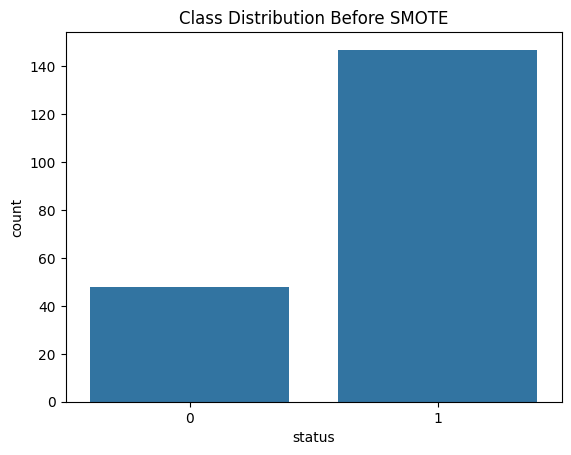

In [11]:
# Explore Class Distribution (Target Variable 'status')
print("\nClass Distribution (0: Healthy, 1: Parkinson's):")
status_counts = df['status'].value_counts()
print(status_counts)

sns.countplot(x='status', data=df)
plt.title('Class Distribution Before SMOTE')
plt.show()

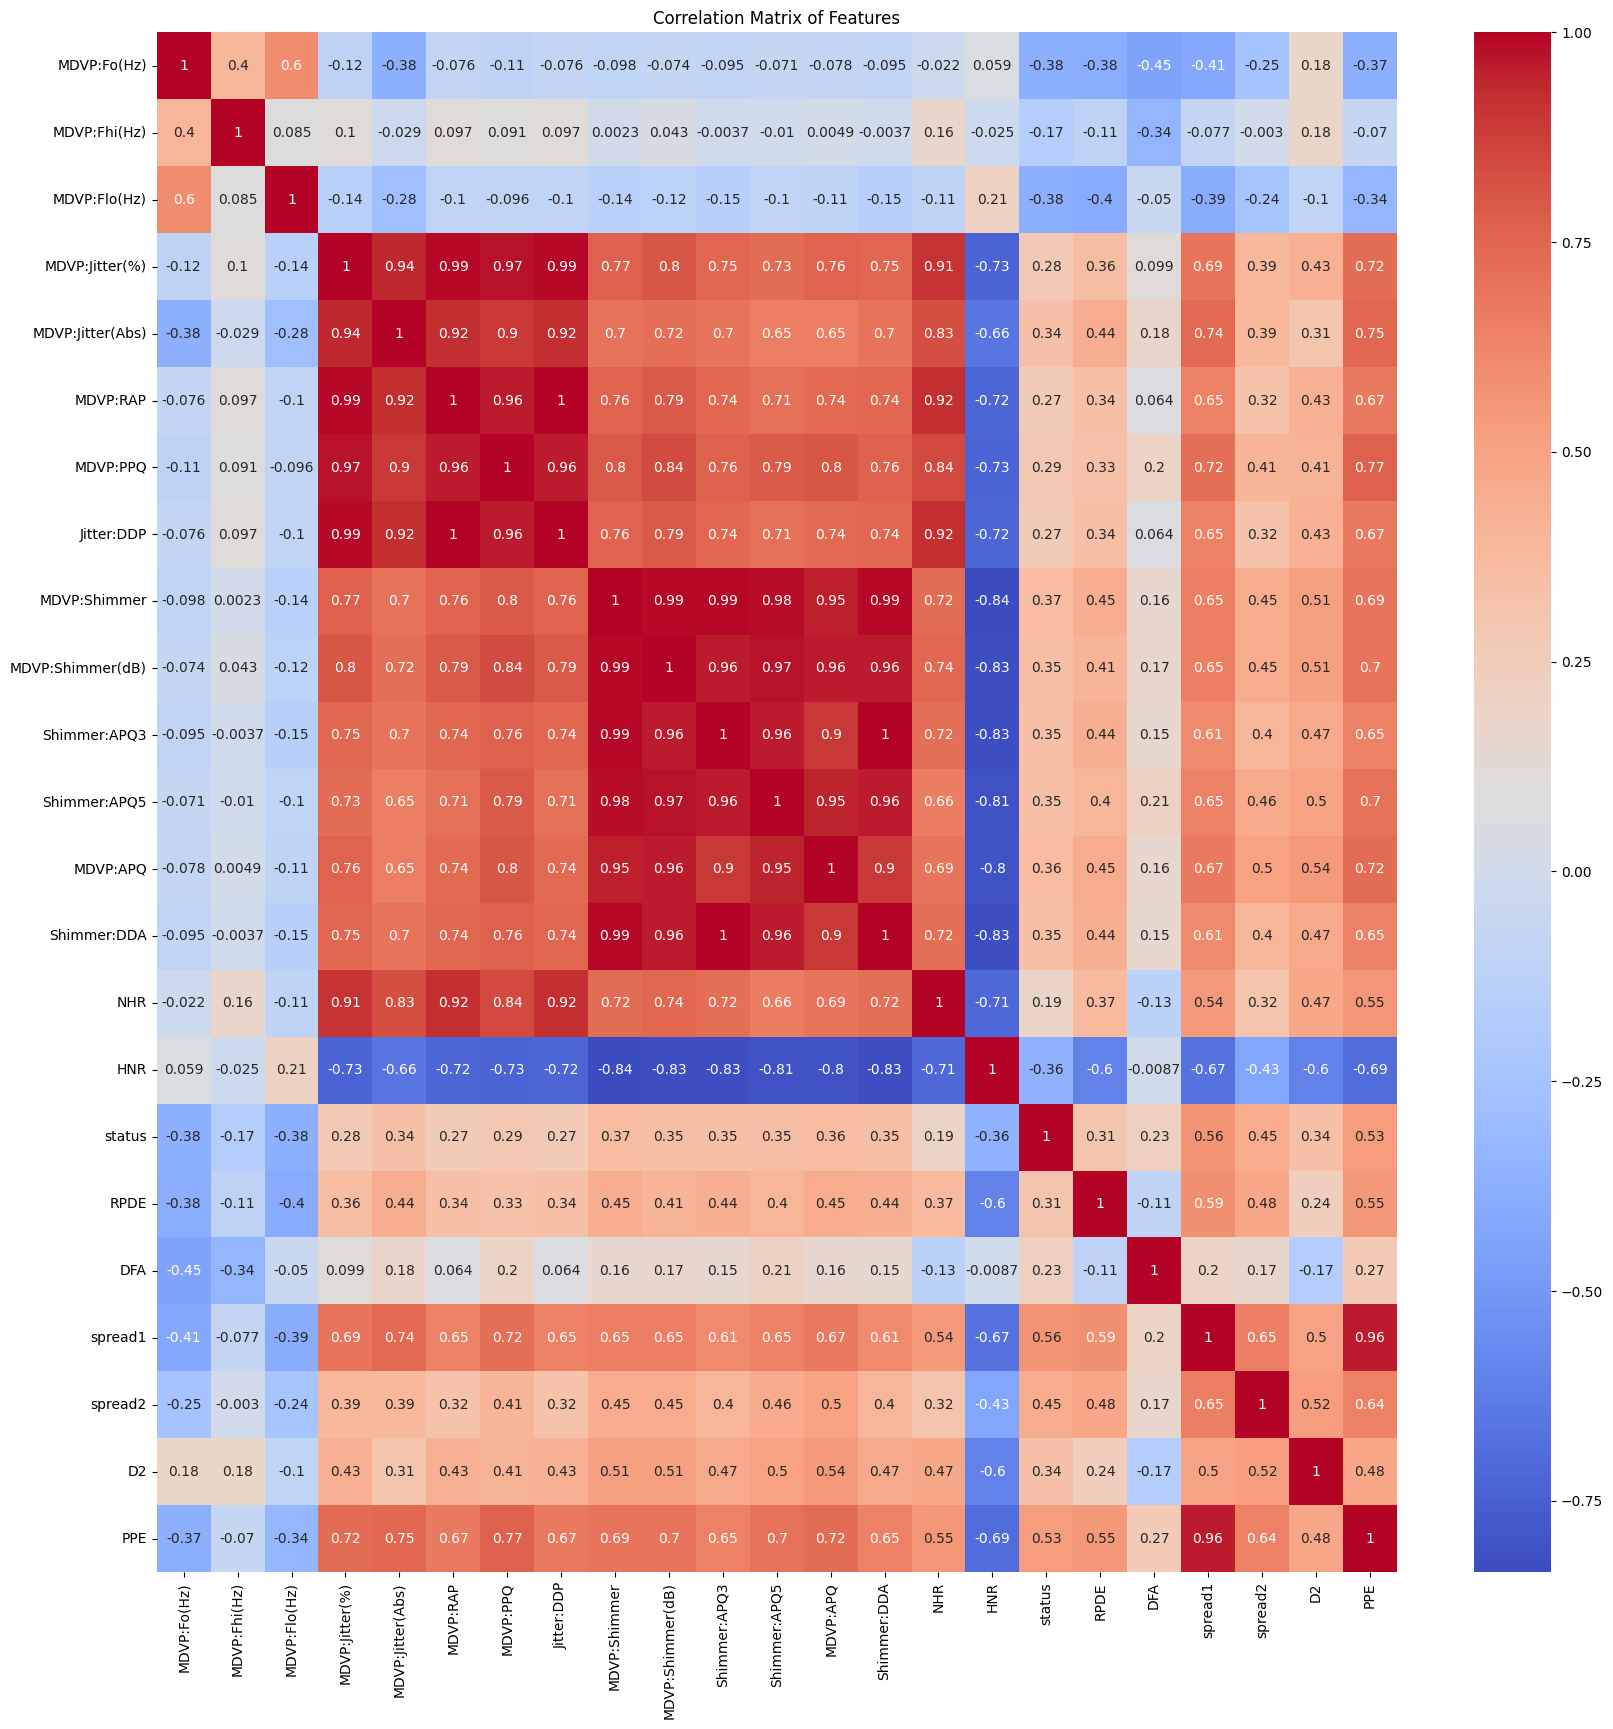

In [12]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,ax=ax, cmap='coolwarm') # Added colormap
plt.title('Correlation Matrix of Features')
plt.show()

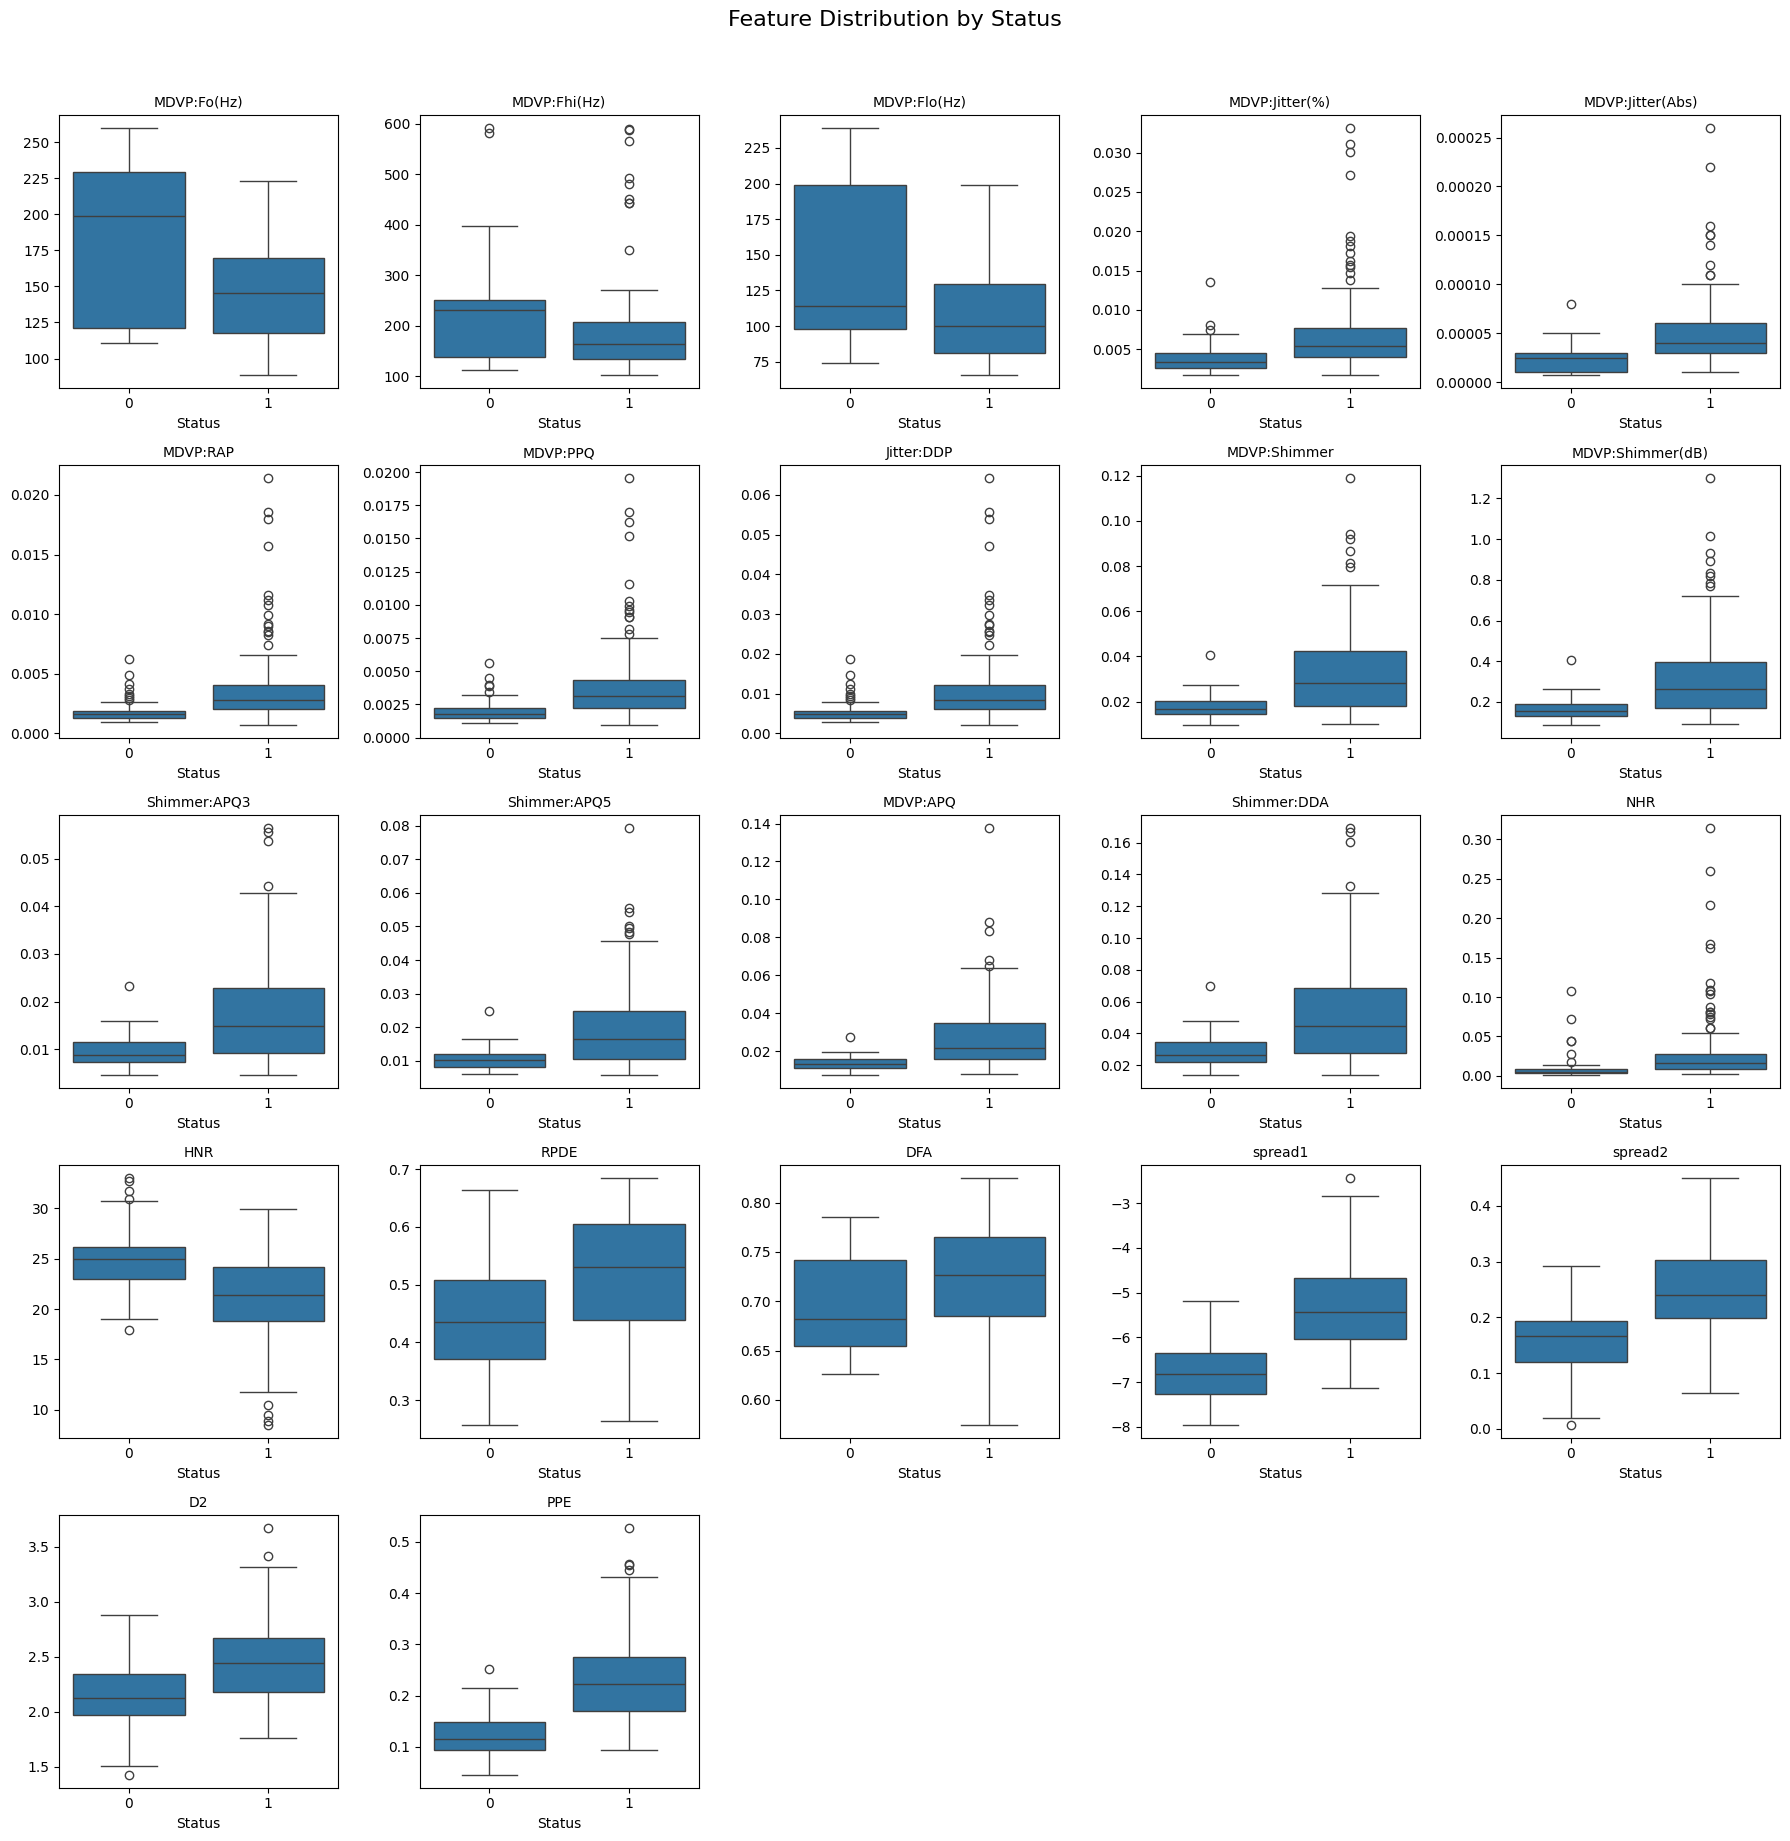

In [13]:
# Box Plot for each feature by status
fig,axes=plt.subplots(5,5,figsize=(18,18))
axes=axes.flatten()

# Ensure columns excluding 'status' are used
feature_cols = [col for col in df.columns if col != 'status']

for i, col in enumerate(feature_cols):
    if i < len(axes): # Ensure we don't exceed the number of axes
        sns.boxplot(x='status', y=df[col], data=df, orient='v', ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('Status')
        axes[i].set_ylabel('') # Remove y-label for clarity
    else:
        break # Stop if we run out of subplots

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Feature Distribution by Status', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
plt.show()

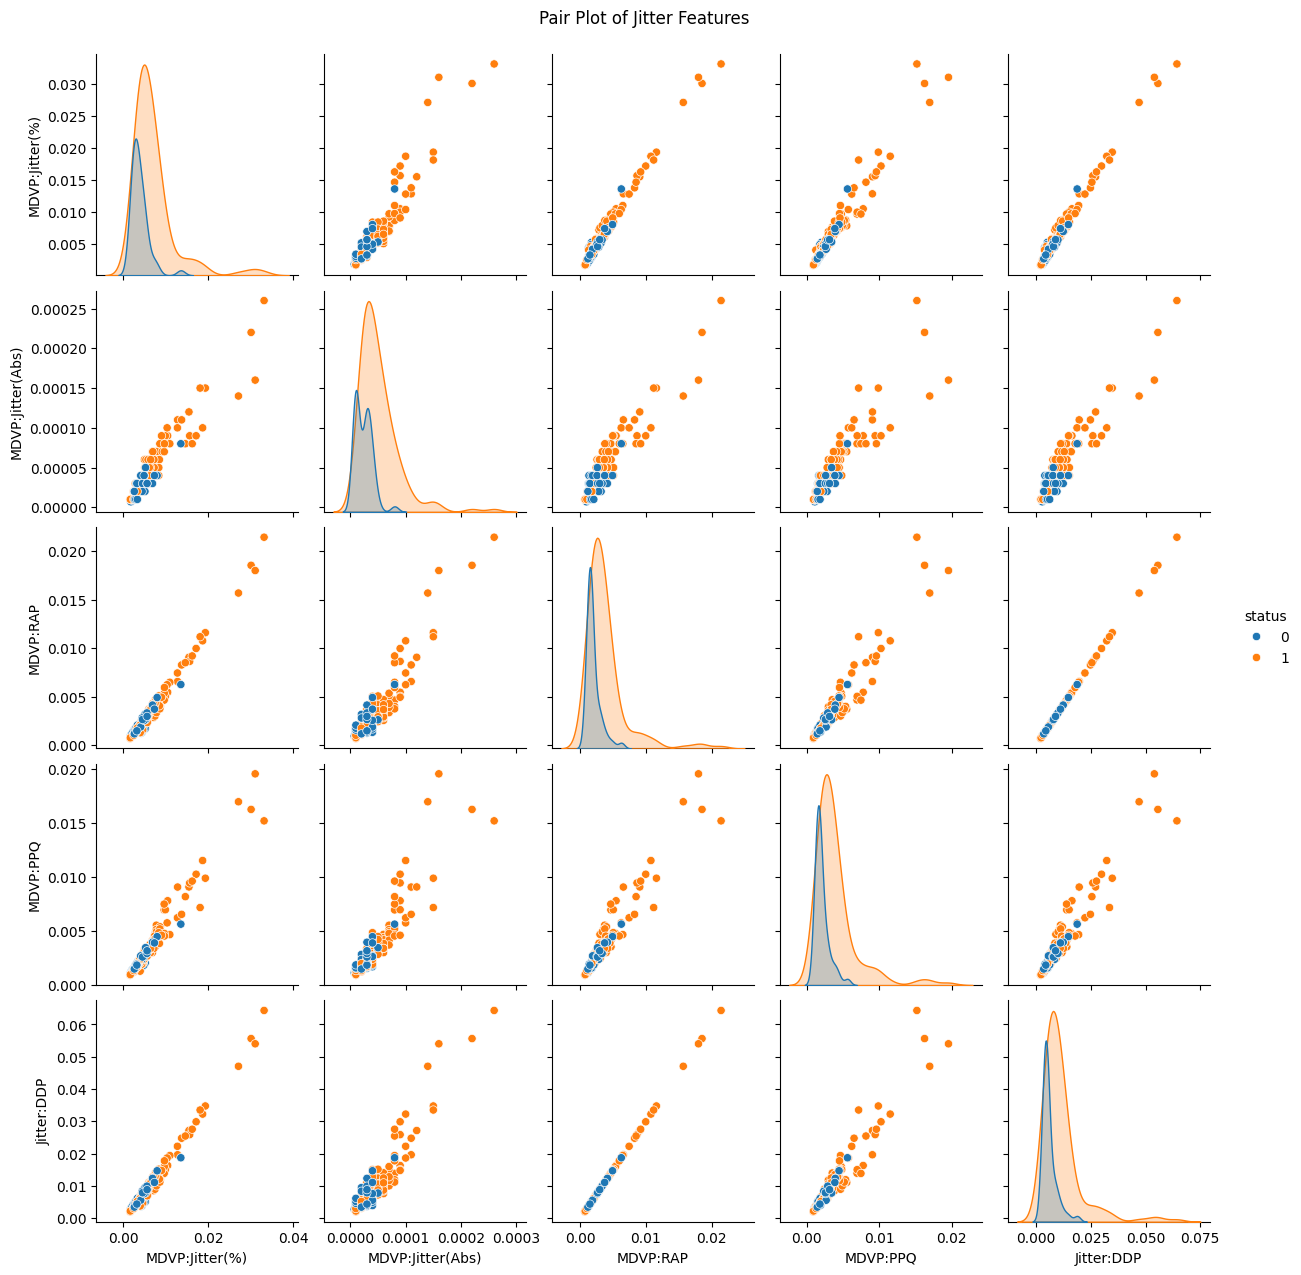

In [14]:
# Pairplot for Jitter features
jitter_cols = ['MDVP:Jitter(%)','MDVP:Jitter(Abs)','MDVP:RAP','MDVP:PPQ', 'Jitter:DDP']
plt.rcParams['figure.figsize'] = (15, 4)
sns.pairplot(df, hue='status', vars=jitter_cols)
plt.suptitle('Pair Plot of Jitter Features', y=1.02)
plt.show()

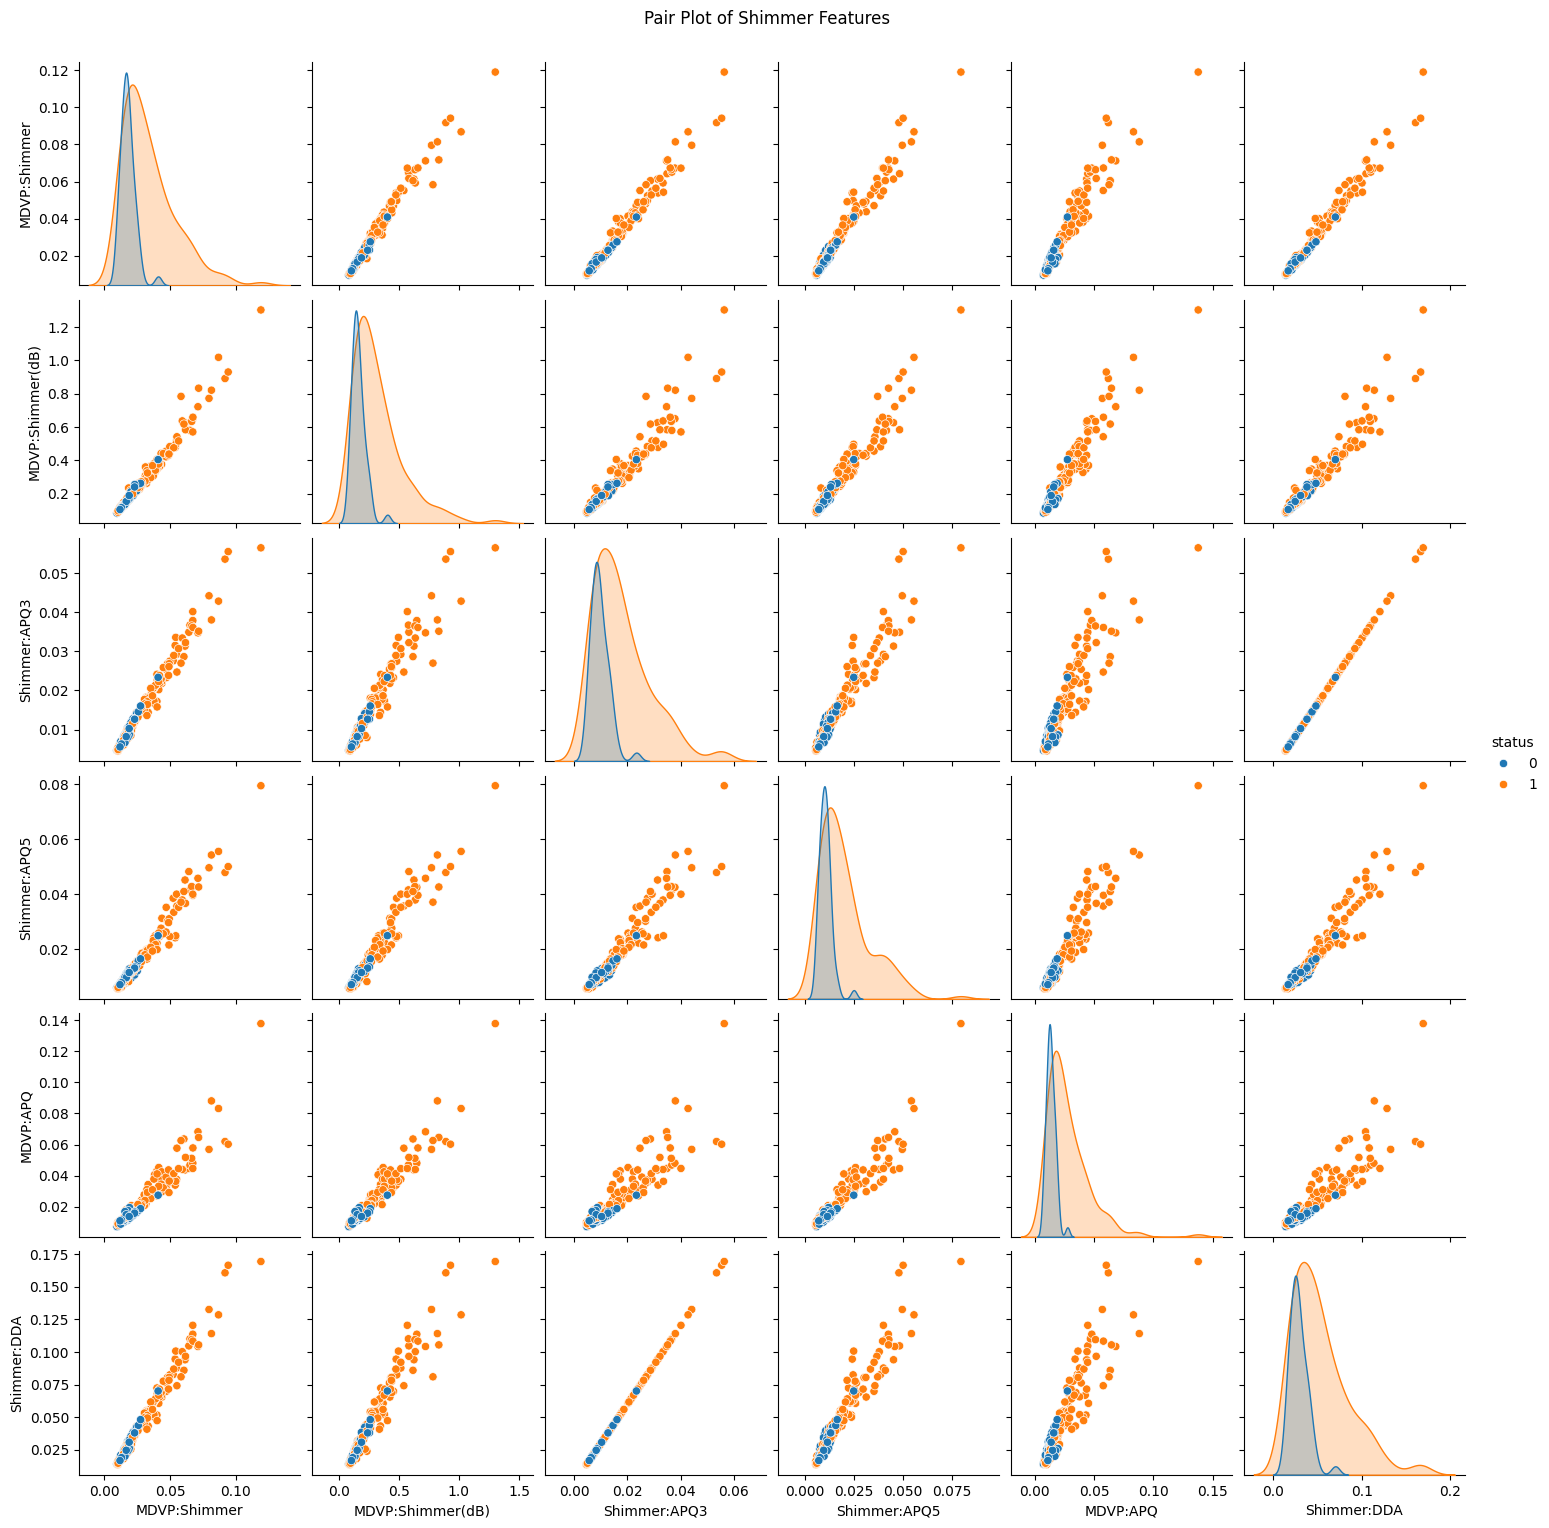

In [15]:
# Pairplot for Shimmer features
shimmer_cols = ['MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','MDVP:APQ','Shimmer:DDA']
plt.rcParams['figure.figsize'] = (15, 4)
sns.pairplot(df, hue='status', vars=shimmer_cols)
plt.suptitle('Pair Plot of Shimmer Features', y=1.02)
plt.show()

### 3.2 Feature/Target Separation and Handling Imbalance (SMOTE)

Feature (X) Shape Before Balancing : (195, 22)
Target (y) Shape Before Balancing : (195,)

Class imbalance detected. Applying SMOTE...
Shape of features after SMOTE: (294, 22)
Class Distribution After SMOTE:
status
1    147
0    147
Name: count, dtype: int64


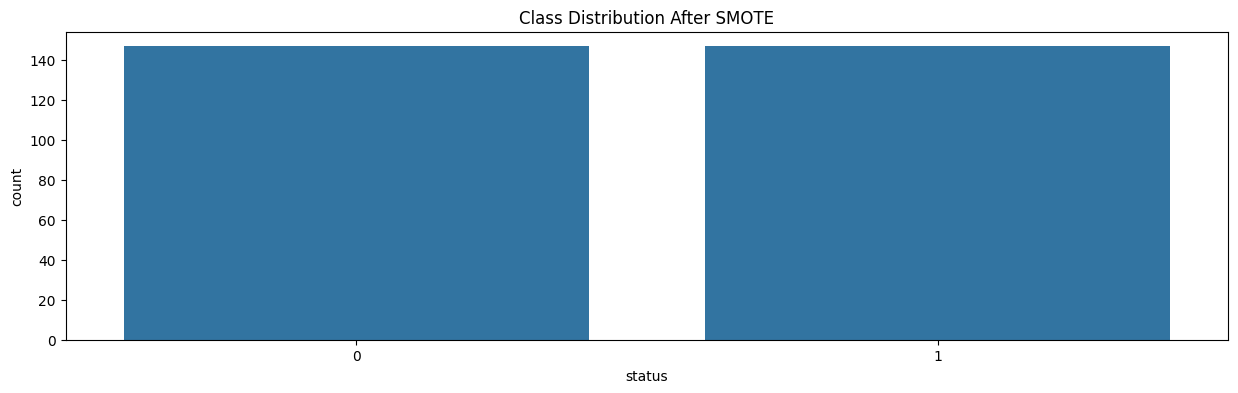

In [16]:
# Separate features (X) and target (y)
X = df.drop(['status'], axis=1)
y = df['status']

print('Feature (X) Shape Before Balancing :', X.shape)
print('Target (y) Shape Before Balancing :', y.shape)

# Check for imbalance again before deciding to apply SMOTE
min_class_count = y.value_counts().min()
max_class_count = y.value_counts().max()

if min_class_count / max_class_count < 0.5: # Example threshold for imbalance
     print("\nClass imbalance detected. Applying SMOTE...")
     smote = SMOTE(random_state=42) # Use a fixed random state for reproducibility
     X_resampled, y_resampled = smote.fit_resample(X, y)
     print(f"Shape of features after SMOTE: {X_resampled.shape}")
     print("Class Distribution After SMOTE:")
     print(y_resampled.value_counts())
     # Optional: Plot distribution after SMOTE
     sns.countplot(x=y_resampled)
     plt.title('Class Distribution After SMOTE')
     plt.show()
else:
     print("\nDataset is relatively balanced or SMOTE not deemed necessary.")
     X_resampled = X.copy() # Use original features
     y_resampled = y.copy() # Use original target

# Store feature names before scaling (from the resampled or original X)
feature_names = X_resampled.columns

### 3.3 Feature Scaling

In [17]:
# Scale features to be between -1 and 1 (as in the original user code)
print("\nApplying Feature Scaling...")
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_resampled)
print("Features scaled using MinMaxScaler to range [-1, 1].")


Applying Feature Scaling...
Features scaled using MinMaxScaler to range [-1, 1].


### 3.4 Train-Test Split

In [18]:
print("\nSplitting data into Training and Testing sets...")
# Split into 80% training and 20% testing data, stratify to maintain class proportion
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.20, random_state=42, stratify=y_resampled
)
print(f"Data split into Train/Test sets:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Splitting data into Training and Testing sets...
Data split into Train/Test sets:
X_train shape: (235, 22), y_train shape: (235,)
X_test shape: (59, 22), y_test shape: (59,)


## 4. Model Training, Tuning, and Evaluation

Initialize dictionaries to store results

In [19]:
models = {}
predictions = {}
probabilities = {} # To store probabilities for AUC

# Define common settings
cv_folds = 5
scoring_metric = 'accuracy' # Can change to 'f1', 'roc_auc' etc.

### 4.1 Decision Tree

In [20]:
print("--- Decision Tree ---")
dt_clf = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': range(3, 11),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}
CV_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid_dt, cv=cv_folds, scoring=scoring_metric, n_jobs=-1)
CV_dt.fit(X_train, y_train)
print(f"Best DT Params: {CV_dt.best_params_}")
dt_best = CV_dt.best_estimator_
models['DT'] = dt_best
predictions['DT'] = dt_best.predict(X_test)
probabilities['DT'] = dt_best.predict_proba(X_test)[:, 1]

--- Decision Tree ---
Best DT Params: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


DT Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.96      0.83      0.89        29

    accuracy                           0.90        59
   macro avg       0.91      0.90      0.90        59
weighted avg       0.91      0.90      0.90        59



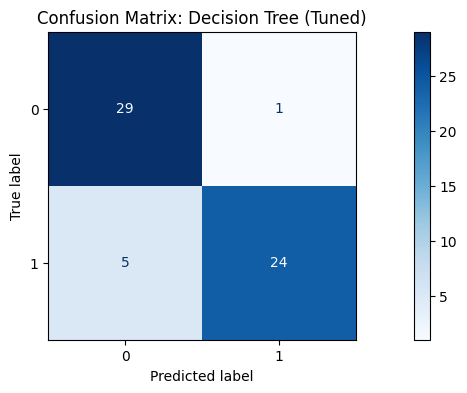

In [21]:
print("DT Classification Report (Test Set):")
print(classification_report(y_test, predictions['DT']))
ConfusionMatrixDisplay.from_estimator(dt_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Decision Tree (Tuned)')
plt.show()

### 4.2 Random Forest

In [22]:
print("\n--- Random Forest ---")
rf_clf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': range(5, 15, 2), # Adjusted range
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}
CV_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=cv_folds, scoring=scoring_metric, n_jobs=-1)
CV_rf.fit(X_train, y_train)
print(f"Best RF Params: {CV_rf.best_params_}")
rf_best = CV_rf.best_estimator_
models['RF'] = rf_best
predictions['RF'] = rf_best.predict(X_test)
probabilities['RF'] = rf_best.predict_proba(X_test)[:, 1]


--- Random Forest ---
Best RF Params: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RF Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



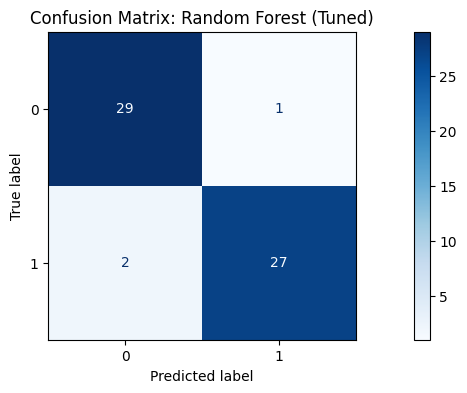

In [23]:
print("RF Classification Report (Test Set):")
print(classification_report(y_test, predictions['RF']))
ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Random Forest (Tuned)')
plt.show()

### 4.3 Logistic Regression

In [24]:
print("\n--- Logistic Regression ---")
log_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
# Optional: Tune C (regularization strength)
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
CV_lr = GridSearchCV(log_model, param_grid_lr, cv=cv_folds, scoring=scoring_metric, n_jobs=-1)
CV_lr.fit(X_train, y_train)
print(f"Best LR Params: {CV_lr.best_params_}")
lr_best = CV_lr.best_estimator_
models['LR'] = lr_best
predictions['LR'] = lr_best.predict(X_test)
probabilities['LR'] = lr_best.predict_proba(X_test)[:, 1]


--- Logistic Regression ---
Best LR Params: {'C': 100}


LR Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.86      0.83      0.84        29

    accuracy                           0.85        59
   macro avg       0.85      0.85      0.85        59
weighted avg       0.85      0.85      0.85        59



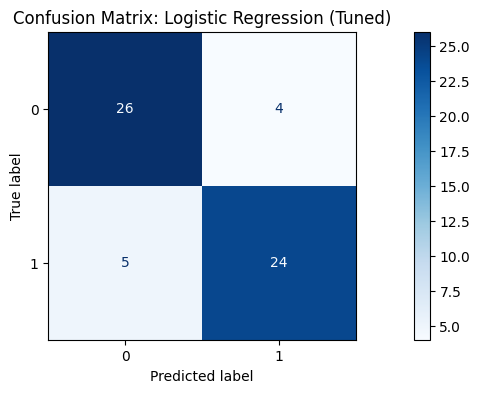

In [25]:
print("LR Classification Report (Test Set):")
print(classification_report(y_test, predictions['LR']))
ConfusionMatrixDisplay.from_estimator(lr_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Logistic Regression (Tuned)')
plt.show()

### 4.4 Support Vector Machine (SVM)

In [26]:
print("\n--- Support Vector Machine (SVM) ---")
svm_clf = SVC(probability=True, random_state=42) # Must have probability=True for predict_proba
param_grid_svm = {'kernel': ['linear', 'rbf'], # Poly can be very slow
                  'C': [0.1, 1, 10, 50], # Expanded C
                  'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]} # Expanded gamma
CV_svm = GridSearchCV(svm_clf, param_grid_svm, cv=cv_folds, scoring=scoring_metric, verbose=1, n_jobs=-1)
CV_svm.fit(X_train, y_train)
print(f"Best SVM Params: {CV_svm.best_params_}")
svm_best = CV_svm.best_estimator_
models['SVM'] = svm_best
predictions['SVM'] = svm_best.predict(X_test)
probabilities['SVM'] = svm_best.predict_proba(X_test)[:, 1]


--- Support Vector Machine (SVM) ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best SVM Params: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


SVM Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        29

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59



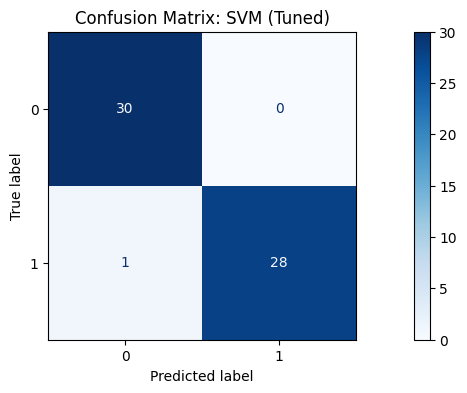

In [27]:
print("SVM Classification Report (Test Set):")
print(classification_report(y_test, predictions['SVM']))
ConfusionMatrixDisplay.from_estimator(svm_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: SVM (Tuned)')
plt.show()

### 4.5 Naive Bayes

In [28]:
print("\n--- Naive Bayes (Gaussian) ---")
nb_clf = GaussianNB()
# Optional: Tune var_smoothing
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
CV_nb = GridSearchCV(estimator=nb_clf, param_grid=param_grid_nb, cv=cv_folds, scoring=scoring_metric, n_jobs=-1)
CV_nb.fit(X_train, y_train)
print(f"Best NB Params: {CV_nb.best_params_}")
nb_best = CV_nb.best_estimator_
models['NB'] = nb_best
predictions['NB'] = nb_best.predict(X_test)
probabilities['NB'] = nb_best.predict_proba(X_test)[:, 1]


--- Naive Bayes (Gaussian) ---
Best NB Params: {'var_smoothing': 0.008111308307896872}


NB Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        30
           1       0.90      0.62      0.73        29

    accuracy                           0.78        59
   macro avg       0.81      0.78      0.77        59
weighted avg       0.81      0.78      0.77        59



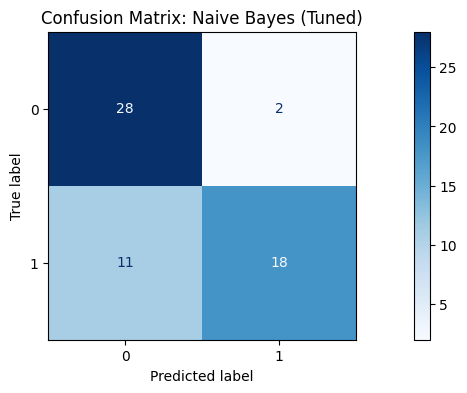

In [29]:
print("NB Classification Report (Test Set):")
print(classification_report(y_test, predictions['NB']))
ConfusionMatrixDisplay.from_estimator(nb_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Naive Bayes (Tuned)')
plt.show()

### 4.6 K-Nearest Neighbors (KNN)

In [30]:
print("\n--- K-Nearest Neighbors (KNN) ---")
knn_clf = KNeighborsClassifier()
# Tune n_neighbors and other params
param_grid_knn = {'n_neighbors': range(1, 11),
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']}
CV_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid_knn, cv=cv_folds, scoring=scoring_metric, n_jobs=-1)
CV_knn.fit(X_train, y_train)
print(f"Best KNN Params: {CV_knn.best_params_}")
knn_best = CV_knn.best_estimator_
models['KNN'] = knn_best
predictions['KNN'] = knn_best.predict(X_test)
probabilities['KNN'] = knn_best.predict_proba(X_test)[:, 1]


--- K-Nearest Neighbors (KNN) ---
Best KNN Params: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


KNN Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59



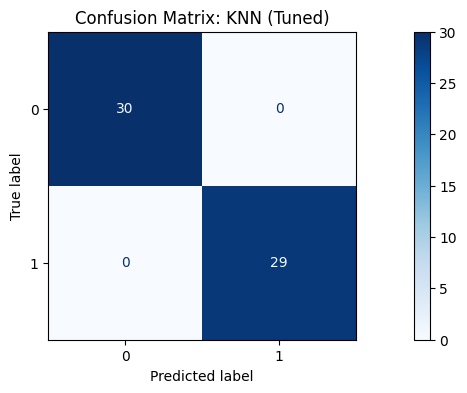

In [31]:
print("KNN Classification Report (Test Set):")
print(classification_report(y_test, predictions['KNN']))
ConfusionMatrixDisplay.from_estimator(knn_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix: KNN (Tuned)')
plt.show()

### 4.7 XGBoost

In [32]:
print("\n--- XGBoost ---")
# Define XGBoost classifier with settings to potentially avoid warnings
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
param_grid_xgb = {'max_depth': [3, 4, 5, 6],
                  'learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'n_estimators': [100, 150, 200],
                  'gamma': [0, 0.1, 0.2],
                  'subsample': [0.7, 0.8, 0.9],
                  'colsample_bytree': [0.7, 0.8, 0.9]
                  }
CV_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=cv_folds, scoring=scoring_metric, verbose=1, n_jobs=-1)
CV_xgb.fit(X_train, y_train)
print(f"Best XGB Params: {CV_xgb.best_params_}")
xgb_best = CV_xgb.best_estimator_
models['XGB'] = xgb_best
predictions['XGB'] = xgb_best.predict(X_test)
probabilities['XGB'] = xgb_best.predict_proba(X_test)[:, 1]


--- XGBoost ---
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best XGB Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.7}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:17:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



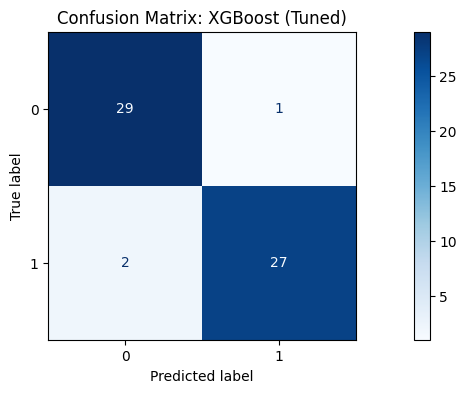

In [33]:
print("XGB Classification Report (Test Set):")
print(classification_report(y_test, predictions['XGB']))
ConfusionMatrixDisplay.from_estimator(xgb_best, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: XGBoost (Tuned)')
plt.show()

## 5. Final Results Comparison

In [34]:
print("\n--- Final Model Performance Comparison (Test Set) ---")

results = []
for name in models.keys(): # Iterate through the keys of the models dictionary
    pred = predictions[name]
    # Ensure probabilities exist for the model (all should now)
    if name in probabilities:
        prob = probabilities[name]
        auc = roc_auc_score(y_test, prob)
    else:
        auc = np.nan # Should not happen with current setup
        print(f"Warning: Probabilities not found for model {name}")

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'AUC-ROC': auc
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4) # Round for clearer display
results_df.set_index('Model', inplace=True)

print("Performance Metrics Summary (Sorted by F1-Score):")
display(results_df.sort_values(by='F1-Score', ascending=False))


--- Final Model Performance Comparison (Test Set) ---
Performance Metrics Summary (Sorted by F1-Score):


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
KNN,1.0000,1.0000,1.0000,1.0000,1.0000
SVM,0.9831,1.0000,0.9655,0.9825,1.0000
RF,0.9492,0.9643,0.9310,0.9474,0.9954
XGB,0.9492,0.9643,0.9310,0.9474,0.9977
DT,0.8983,0.9600,0.8276,0.8889,0.8971
LR,0.8475,0.8571,0.8276,0.8421,0.9598
NB,0.7797,0.9000,0.6207,0.7347,0.8782


## 6. Plot Combined ROC Curves


--- Plotting ROC Curves ---


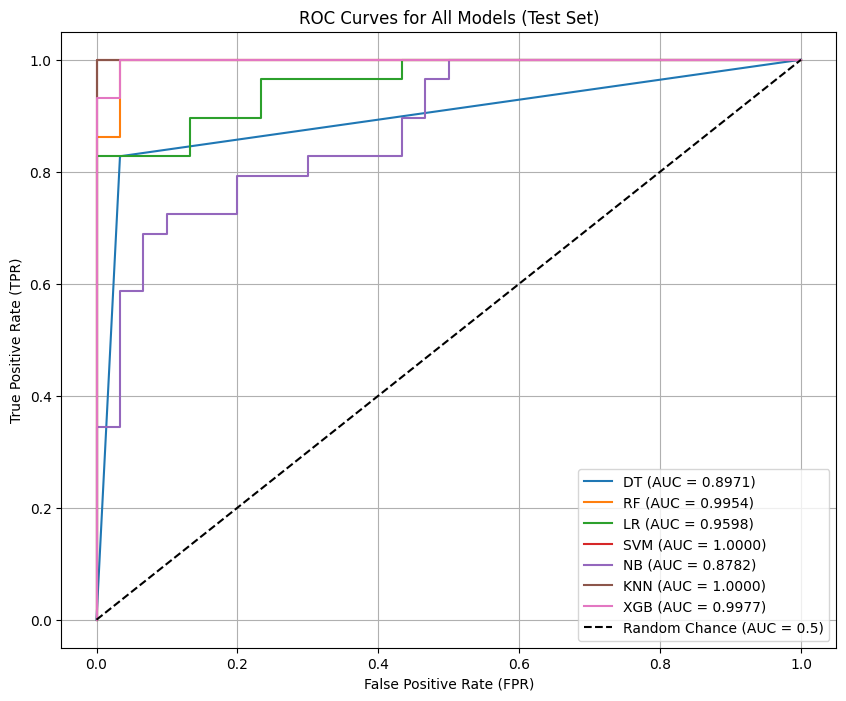

In [35]:
print("\n--- Plotting ROC Curves ---")
plt.figure(figsize=(10, 8))
for name in models.keys():
     if name in probabilities:
        prob = probabilities[name]
        fpr, tpr, _ = roc_curve(y_test, prob)
        auc = results_df.loc[name, 'AUC-ROC']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
     else:
        print(f"Skipping ROC curve for {name} due to missing probabilities.")


plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for All Models (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 7. Feature Importance Analysis (Example for RF and XGB)


--- Feature Importance Analysis ---


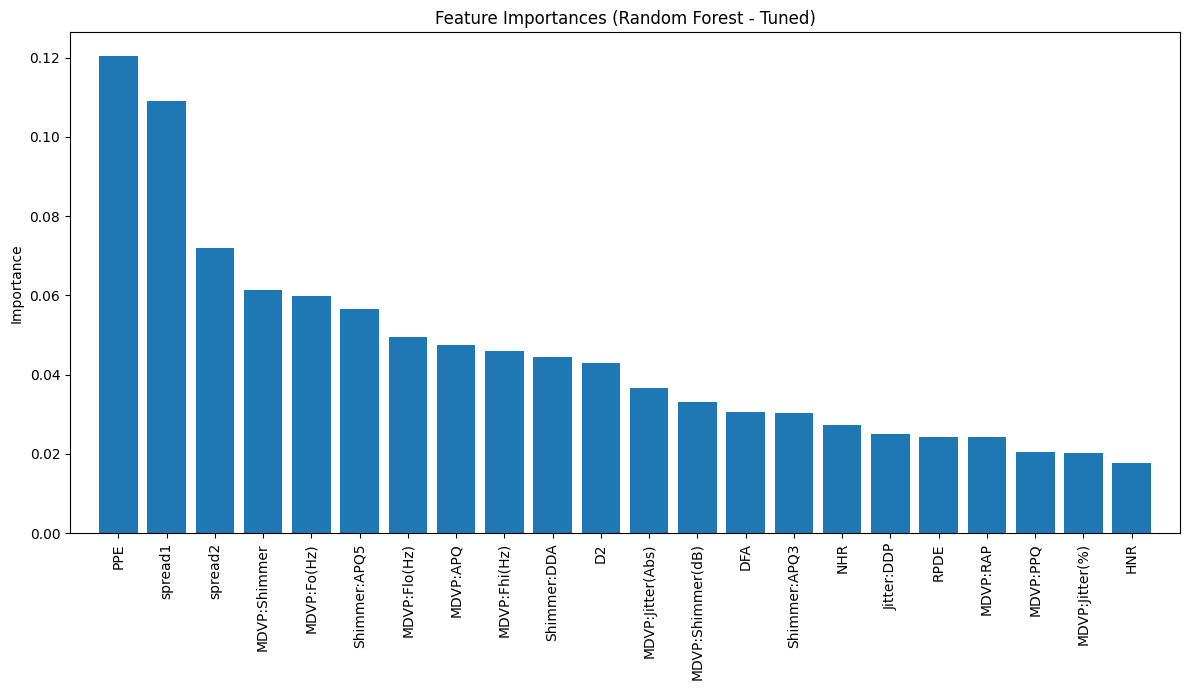


Top 5 RF Features:
1. PPE (0.1203)
2. spread1 (0.1090)
3. spread2 (0.0719)
4. MDVP:Shimmer (0.0615)
5. MDVP:Fo(Hz) (0.0599)


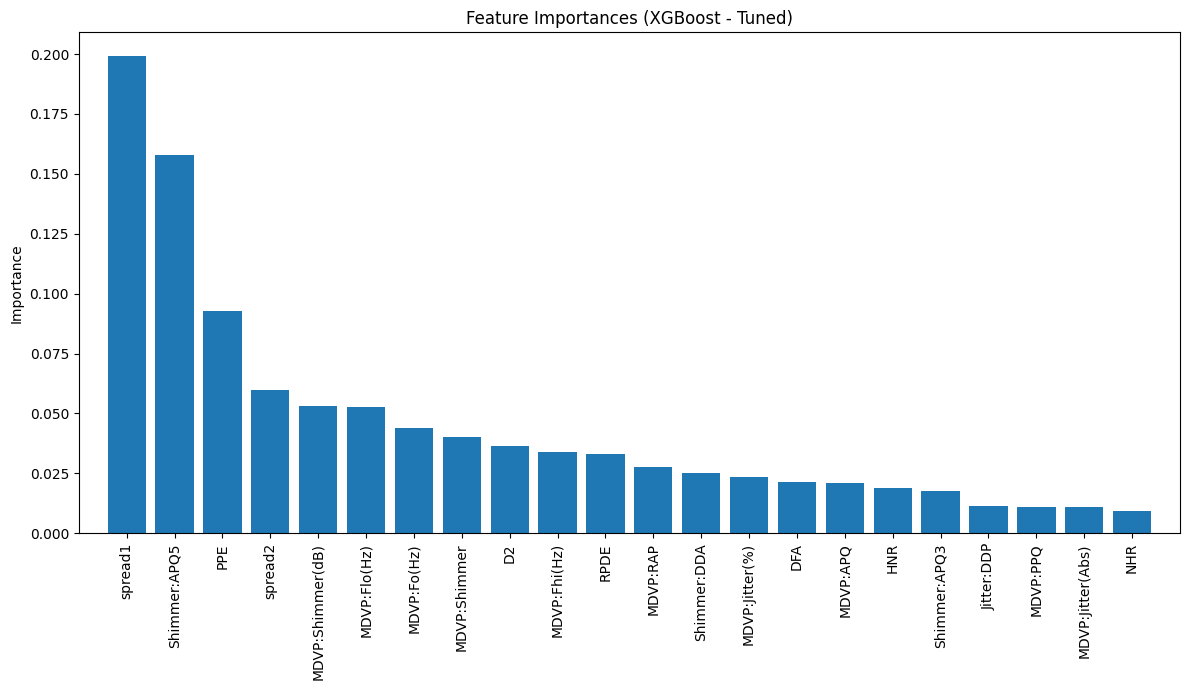


Top 5 XGBoost Features:
1. spread1 (0.1991)
2. Shimmer:APQ5 (0.1578)
3. PPE (0.0926)
4. spread2 (0.0596)
5. MDVP:Shimmer(dB) (0.0533)

--- Analysis Complete ---


In [36]:
print("\n--- Feature Importance Analysis ---")

# Ensure feature_names were captured correctly earlier
if 'feature_names' not in locals() or feature_names is None:
     print("Error: feature_names not defined. Cannot show feature importance.")
else:
    # Random Forest Feature Importance
    if 'RF' in models:
        importances_rf = models['RF'].feature_importances_
        indices_rf = np.argsort(importances_rf)[::-1]
        plt.figure(figsize=(12, 7))
        plt.title("Feature Importances (Random Forest - Tuned)")
        plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
        # Ensure correct indexing for feature names
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices_rf], rotation=90)
        plt.xlim([-1, X_train.shape[1]])
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
        print("\nTop 5 RF Features:")
        for i in range(min(5, len(feature_names))):
            print(f"{i+1}. {feature_names[indices_rf[i]]} ({importances_rf[indices_rf[i]]:.4f})")

    # XGBoost Feature Importance
    if 'XGB' in models:
        importances_xgb = models['XGB'].feature_importances_
        indices_xgb = np.argsort(importances_xgb)[::-1]
        plt.figure(figsize=(12, 7))
        plt.title("Feature Importances (XGBoost - Tuned)")
        plt.bar(range(X_train.shape[1]), importances_xgb[indices_xgb], align="center")
        # Ensure correct indexing for feature names
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices_xgb], rotation=90)
        plt.xlim([-1, X_train.shape[1]])
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
        print("\nTop 5 XGBoost Features:")
        for i in range(min(5, len(feature_names))):
             print(f"{i+1}. {feature_names[indices_xgb[i]]} ({importances_xgb[indices_xgb[i]]:.4f})")


print("\n--- Analysis Complete ---")

## 8. Appendix: Project Visualizations (Gantt, Kanban, Block Diagram)

### Gantt Chart

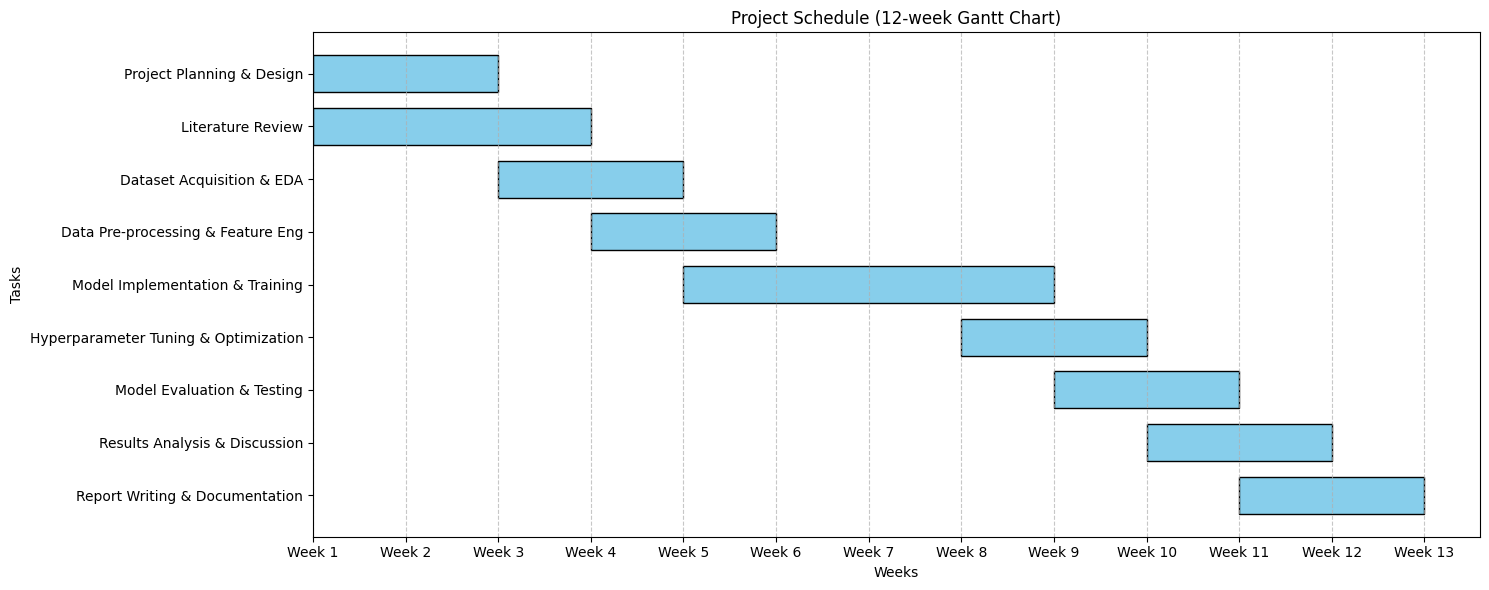

In [37]:
# Code to generate Gantt Chart (as provided previously)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Define tasks and their start and end weeks
tasks = [
    ("Project Planning & Design", 1, 2),
    ("Literature Review", 1, 3),
    ("Dataset Acquisition & EDA", 3, 4),
    ("Data Pre-processing & Feature Eng", 4, 5),
    ("Model Implementation & Training", 5, 8),
    ("Hyperparameter Tuning & Optimization", 8, 9),
    ("Model Evaluation & Testing", 9, 10),
    ("Results Analysis & Discussion", 10, 11),
    ("Report Writing & Documentation", 11, 12)
]

# Create a DataFrame
df_gantt = pd.DataFrame(tasks, columns=["Task", "Start Week", "End Week"])

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through tasks to create bars for each task
for idx, row in df_gantt.iterrows():
    ax.barh(row['Task'], row['End Week'] - row['Start Week'] + 1, left=row['Start Week'], height=0.7, color='skyblue', edgecolor='black') # Add 1 for duration

# Formatting the plot
ax.set_xlabel("Weeks")
ax.set_ylabel("Tasks")
ax.set_title("Project Schedule (12-week Gantt Chart)")

# Set x-ticks to correspond to weeks
ax.set_xticks(np.arange(1, 14)) # Go up to 13 to include Week 12 fully
ax.set_xticklabels([f"Week {i}" for i in range(1, 14)])
ax.invert_yaxis() # Display tasks from top to bottom

# Adjusting grid and layout
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### Kanban Board

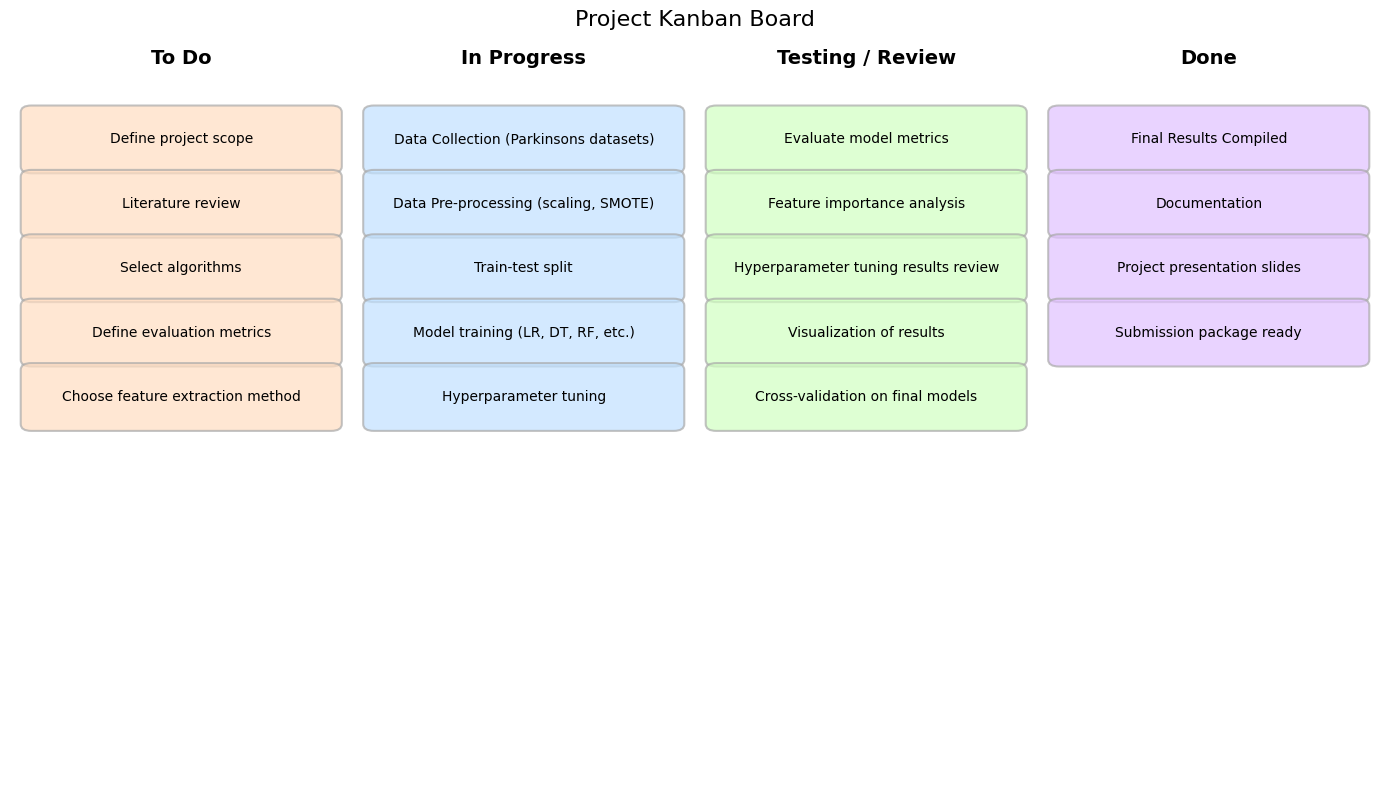

In [38]:
# Code to generate Kanban Chart (as provided previously)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define columns and tasks
columns = ['To Do', 'In Progress', 'Testing / Review', 'Done']
tasks = {
    'To Do': [
        'Define project scope',
        'Literature review',
        'Select algorithms',
        'Define evaluation metrics',
        'Choose feature extraction method'
    ],
    'In Progress': [
        'Data Collection (Parkinsons datasets)', # Updated dataset name
        'Data Pre-processing (scaling, SMOTE)',
        'Train-test split',
        'Model training (LR, DT, RF, etc.)',
        'Hyperparameter tuning'
    ],
    'Testing / Review': [
        'Evaluate model metrics',
        'Feature importance analysis',
        'Hyperparameter tuning results review',
        'Visualization of results',
        'Cross-validation on final models'
    ],
    'Done': [
        'Final Results Compiled',
        'Documentation',
        'Project presentation slides',
        'Submission package ready'
    ]
}

# Colors for each column
colors = ['#FFDDC1', '#C1E1FF', '#D1FFC1', '#E1C1FF']

# Plot setup
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')

column_width = 3 # Increased width
padding = 0.1
box_height = 0.8 # Increased height
v_spacing = 0.15 # Vertical spacing

for col_idx, column in enumerate(columns):
    x = col_idx * (column_width + padding * 2) # Adjust x based on width and padding
    column_tasks = tasks[column]
    color = colors[col_idx % len(colors)]

    # Draw column background (optional, can look cluttered)
    # ax.add_patch(plt.Rectangle((x, 0), column_width, 1.1, color=color, alpha=0.1))
    ax.text(x + column_width / 2, 10.5, column, ha='center', va='bottom', fontsize=14, weight='bold', color='black') # Adjusted position

    # Add task boxes
    for t_idx, task in enumerate(column_tasks):
        y = 10 - (t_idx + 1) * (box_height + v_spacing) # Adjusted y position and spacing
        # Rounded rectangle for task
        task_box = patches.FancyBboxPatch(
            (x + padding, y), # Position
            column_width - 2 * padding, # Width
            box_height, # Height
            boxstyle="round,pad=0.1,rounding_size=0.1", # More rounded
            linewidth=1.5, # Thicker border
            edgecolor='darkgrey', # Grey border
            facecolor=color, # Use column color for background
            alpha=0.7
        )
        ax.add_patch(task_box)
        ax.text(x + column_width / 2, y + box_height / 2, task,
                ha='center', va='center', fontsize=10, wrap=True, color='black')

# Set limits
ax.set_xlim(-padding, (column_width + padding * 2) * len(columns) - padding)
ax.set_ylim(0, 11) # Adjust y limit
plt.title("Project Kanban Board", fontsize=16)
plt.tight_layout()
plt.show()

### Block Diagram

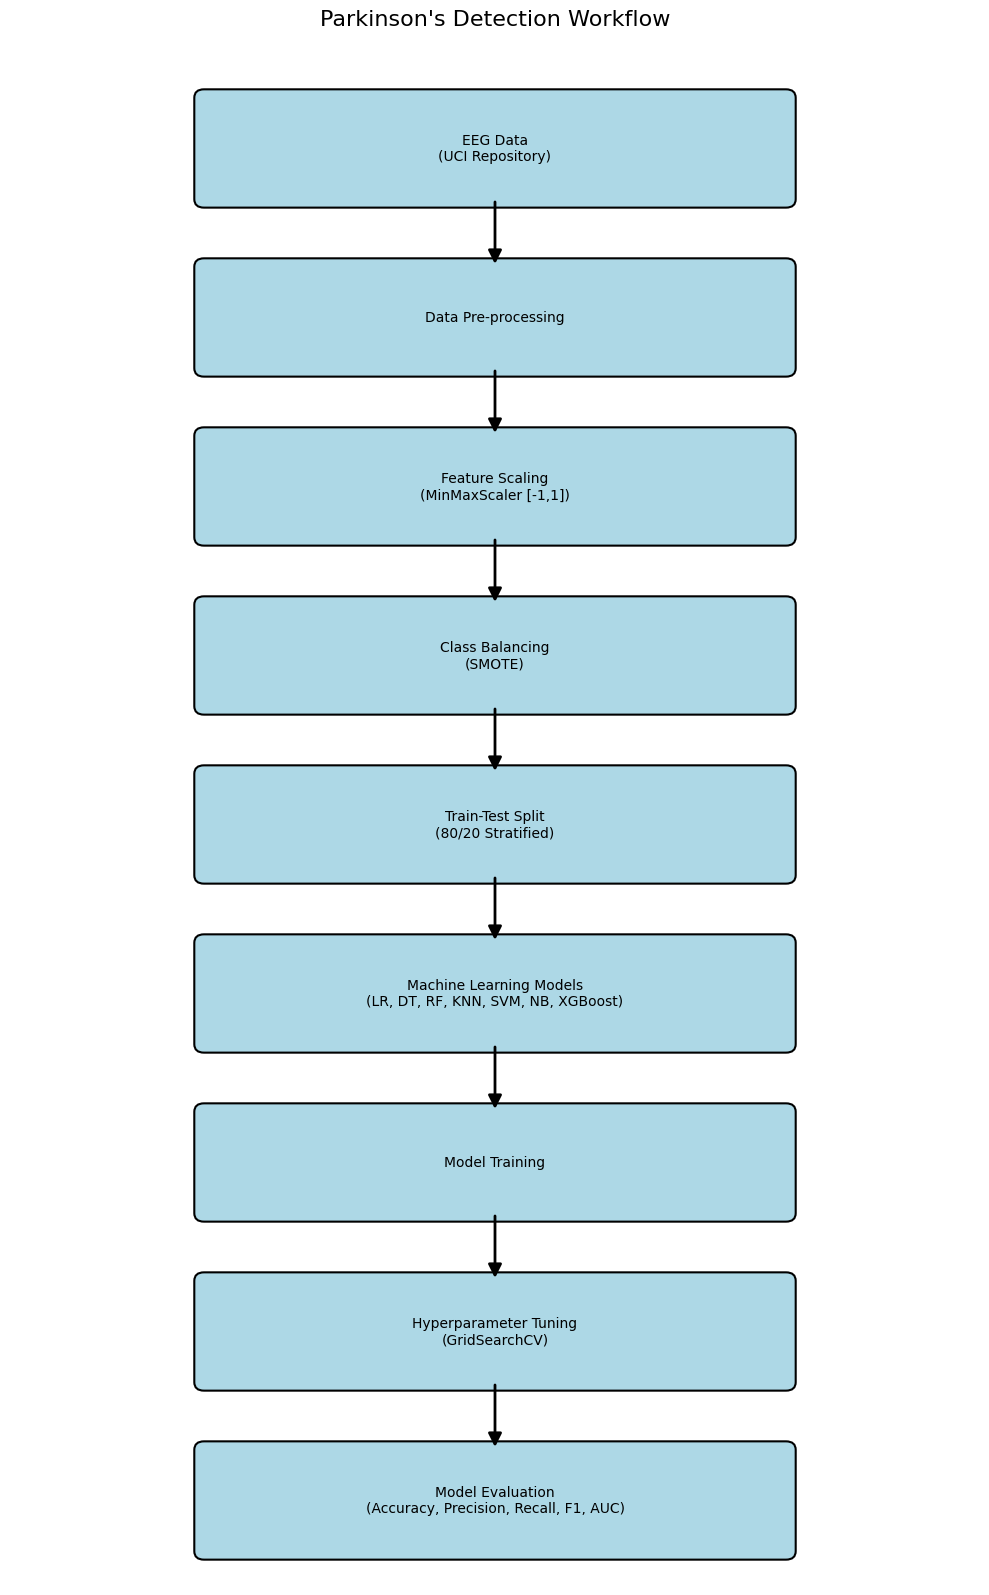

In [39]:
# Code to generate Block Diagram (as provided previously)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 16))
ax.set_xlim(0, 10)
ax.set_ylim(0, 18)
ax.axis('off')

# Helper function to draw a box with centered text and custom styling
def draw_box(text, center, width=6, height=1.2, facecolor='lightblue', edgecolor='black', fontsize=10, fontweight='normal'):
    x, y = center
    rect = patches.FancyBboxPatch((x - width/2, y - height/2),
                                  width, height,
                                  boxstyle="round,pad=0.1,rounding_size=0.1",
                                  facecolor=facecolor,
                                  edgecolor=edgecolor,
                                  linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight=fontweight, wrap=True)

# Block coordinates and text
blocks = {
    "EEG Data\n(UCI Repository)": (5, 17),
    "Data Pre-processing": (5, 15),
    "Feature Scaling\n(MinMaxScaler [-1,1])": (5, 13),
    "Class Balancing\n(SMOTE)": (5, 11),
    "Train-Test Split\n(80/20 Stratified)": (5, 9),
    "Machine Learning Models\n(LR, DT, RF, KNN, SVM, NB, XGBoost)": (5, 7),
    "Model Training": (5, 5),
    "Hyperparameter Tuning\n(GridSearchCV)": (5, 3),
    "Model Evaluation\n(Accuracy, Precision, Recall, F1, AUC)": (5, 1)
    # Removed Feature Importance block from main flow as it's often done post-evaluation
}

# Draw blocks
for text, center in blocks.items():
    draw_box(text, center)

# Arrows with styling
arrow_props = dict(arrowstyle='-|>', color='black', linewidth=2, mutation_scale=20)

# Connect blocks sequentially
block_keys = list(blocks.keys())
for i in range(len(block_keys) - 1):
    start_pos = (blocks[block_keys[i]][0], blocks[block_keys[i]][1] - 0.6) # Adjust arrow start/end points
    end_pos = (blocks[block_keys[i+1]][0], blocks[block_keys[i+1]][1] + 0.6)
    ax.annotate('', xy=end_pos, xytext=start_pos, arrowprops=arrow_props)

# Optional: Add Feature Importance as a separate analysis step
# draw_box("Feature Importance\nAnalysis", (5, -1), facecolor='lightgreen')
# ax.annotate('', xy=(5, 0.2), xytext=blocks["Model Evaluation\n(Accuracy, Precision, Recall, F1, AUC)"][:2], arrowprops=arrow_props)

plt.title("Parkinson's Detection Workflow", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()